<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]"
IPython,7.21.0
MatPlotLib,3.3.4
Numpy,1.20.1
pyAgrum,0.19.3.9


# Credal Net from BN

In [27]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
  bn_min.cpt(n).scale(0.9)
  bn_max.cpt(n).scale(1.1)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.sideBySide(bn.cpt("B"),bn_min.cpt("B"),bn_max.cpt("B"))
cn

(gum::credal::CredalNet<double>@00000228E49A8740) 
A[0,1]
<> : [[0.00844119 , 0.991559] , [0.0103169 , 0.989683]]

B[0,2]
<A:0> : [[0.234467 , 0.410128 , 0.355405] , [0.234467 , 0.458025 , 0.307509] , [0.251188 , 0.458025 , 0.290787] , [0.286571 , 0.422642 , 0.290787] , [0.269847 , 0.374747 , 0.355405] , [0.286571 , 0.374747 , 0.338682]]
<A:1> : [[0.0425401 , 0.391043 , 0.566417] , [0.0519952 , 0.391043 , 0.556962] , [0.0425401 , 0.477943 , 0.479517] , [0.0519952 , 0.477943 , 0.470062]]

C[0,1]
<B:0|D:0> : [[0.517296 , 0.482704] , [0.605061 , 0.394939]]
<B:1|D:0> : [[0.731446 , 0.268554] , [0.780275 , 0.219725]]
<B:2|D:0> : [[0.231988 , 0.768012] , [0.283541 , 0.716459]]
<B:0|D:1> : [[0.666762 , 0.333238] , [0.72735 , 0.27265]]
<B:1|D:1> : [[0.979595 , 0.0204045] , [0.983306 , 0.0166945]]
<B:2|D:1> : [[0.454155 , 0.545845] , [0.553398 , 0.446602]]

D[0,1]
<A:0> : [[0.297332 , 0.702668] , [0.363404 , 0.636596]]
<A:1> : [[0.455714 , 0.544286] , [0.554675 , 0.445325]]

E[0,1]
<A:0> : [[0.380612 , 0.619388] , [0.465193 , 0.534807]]
<A:1> : [[0.122814 , 0.877186] , [0.150104 , 0.849896]]

F[0,1]
<E:0> : [[0.36534 , 0.63466] , [0.446526 , 0.553474]]
<E:1> : [[0.0657792 , 0.934221] , [0.0803975 , 0.919603]]

#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [28]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeCPTMinMax()

gnb.sideBySide(cn,cn2)

Here, $B$ becomes 
- $B-bit-i$ : the $i$-th bit of B
- instrumental $I-B-k$ : the indicator variable for each modality $k$ of $B$

In [29]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

ie_mc.makeInference()
ie2_lbp.makeInference()
ie2_mc.makeInference()

In [30]:
gnb.sideBySide(ie_mc.CN(),ie_mc.marginalMin("F"),ie_mc.marginalMax("F"))

In [32]:
gnb.sideBySide(gnb.getInference(cn,ie_mc),gnb.getInference(cn2,ie2_mc),gnb.getInference(cn2,ie2_lbp))

## Credal Net from bif files

In [9]:
cn=gum.CredalNet(os.path.join("res","cn/2Umin.bif"),os.path.join("res","cn/2Umax.bif"))
cn.intervalToCredal()

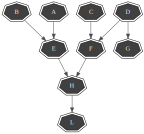

In [10]:
gnb.showCN(cn,"2")

In [11]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile(os.path.join("res","cn/L2U.evi"))

In [12]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [13]:
gnb.sideBySide(cn,gnb.getInference(cn,targets={"A","H","L","D"},engine=ie,evs={"L":[0,1],"G":[1,0]}))

# Comparing inference in credal networks

In [14]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)[:]
        c,d=mc.marginalMax(i)[:]
        
        e,f=lbp.marginalMin(i)[:]
        g,h=lbp.marginalMax(i)[:]
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()
cn.computeCPTMinMax()

#### The two inference give quite the same result

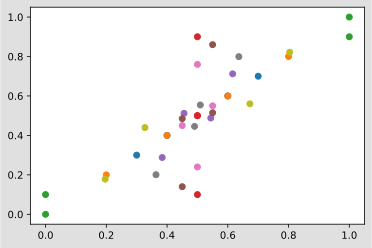

In [15]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

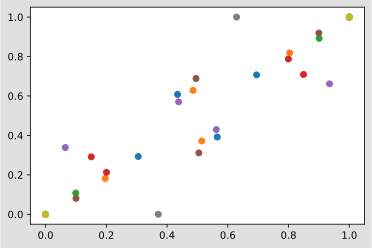

In [16]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [17]:
cn=gum.CredalNet(os.path.join("res","cn/bn_c_8.bif"),os.path.join("res","cn/den_c_8.bif"))
cn.bnToCredal(0.8,False)

In [18]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(True)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()

In [19]:
print(ie.dynamicExpMax("temp"))

(13.796595327558295, 11.584229446656618, 11.88307883632407, 11.93469451600169, 11.872658742263248, 11.892833789993693, 11.889478339857234, 11.889130263747417, 11.889595026433188)


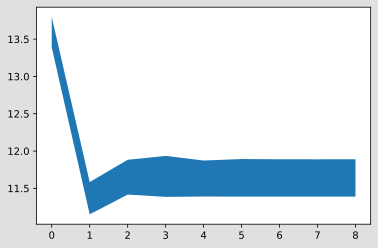

In [20]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [21]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()


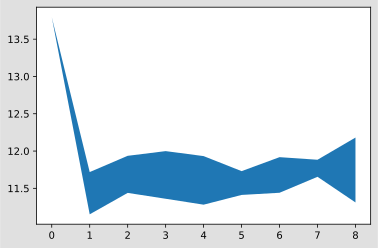

In [22]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

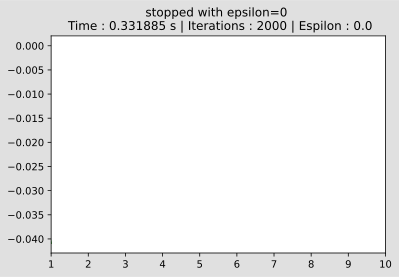

In [23]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(2000)

gnb.animApproximationScheme(ie)
ie.makeInference()

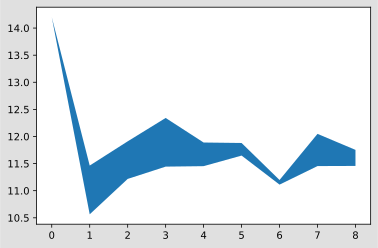

In [24]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));